## Predicting User Adoption
Problem Statement

The objective of this analysis is to identify factors that predict user adoption, defined as a user logging into the product on three or more distinct days within any seven day period. Understanding these drivers enables targeted improvements to onboarding, acquisition, and early engagement strategies.

Data and Methodology

Two datasets were used: a user level table containing signup attributes and a daily login activity table. Login timestamps were converted to datetime and deduplicated at the user day level to avoid overcounting multiple logins on the same day. The two datasets were merged on user ID, and users who never met the adoption criterion were labeled as non adopted.

Feature Engineering

Features were constructed using only information available early in the user lifecycle. These included signup source (creation_source), invitation status, marketing email flags, and time from account creation to first login. Categorical variables were one hot encoded, and continuous features were standardized as needed.

Modeling Approach

A logistic regression model was used to predict adoption due to its interpretability and suitability for binary outcomes. Model coefficients were analyzed to understand the relative importance and direction of each feature rather than to optimize predictive performance. Class imbalance was considered when interpreting results.

Key Findings

Signup source was the strongest predictor of adoption. Users joining via organizational invitations or Google authentication adopted at significantly higher rates than users who signed up independently. Early engagement was also critical: users who logged in shortly after account creation were far more likely to adopt. Invitation based signups showed higher adoption rates, suggesting strong network effects. In contrast, marketing email enrollment showed little predictive power.

Recommendations

Product and growth teams should prioritize reducing friction during early onboarding and encouraging meaningful engagement within the first 24 to 48 hours. Referral and organization based acquisition channels should be emphasized, as they consistently produce higher quality users. Marketing efforts should shift from passive email campaigns toward behavior triggered onboarding interventions. Future analysis should incorporate richer usage metrics and controlled experiments to validate causal relationships.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

In [13]:
users = pd.read_csv("takehome_users.csv", encoding="latin1")
engagement = pd.read_csv("takehome_user_engagement.csv", encoding="latin1")

In [14]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement['login_date'] = engagement['time_stamp'].dt.date

In [15]:
daily_logins = engagement.drop_duplicates(['user_id', 'login_date'])

In [16]:
def is_adopted(df):
    dates = df['login_date'].sort_values().reset_index(drop=True)
    for i in range(len(dates) - 2):
        if (dates[i+2] - dates[i]).days <= 6:
            return 1
    return 0

adoption = (
    daily_logins
    .groupby('user_id')
    .apply(is_adopted)
    .reset_index(name='adopted')
)

In [17]:
users = users.merge(adoption, left_on='object_id', right_on='user_id', how='left')
users['adopted'] = users['adopted'].fillna(0)

In [18]:
first_login = (
    engagement.groupby('user_id')['time_stamp']
    .min()
    .reset_index(name='first_login')
)

users = users.merge(first_login, left_on='object_id', right_on='user_id', how='left')

users['creation_time'] = pd.to_datetime(users['creation_time'])
users['time_to_first_login'] = (
    users['first_login'] - users['creation_time']
).dt.total_seconds() / 3600

In [19]:
users['invited'] = users['invited_by_user_id'].notnull().astype(int)

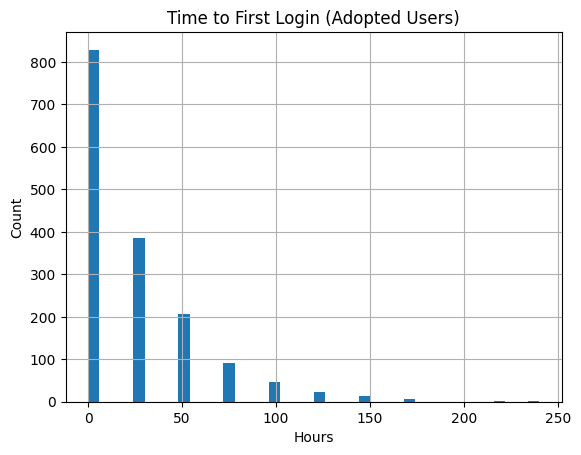

In [20]:
plt.figure()
users[users['adopted'] == 1]['time_to_first_login'].hist(bins=40)
plt.title("Time to First Login (Adopted Users)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.show()

<Figure size 640x480 with 0 Axes>

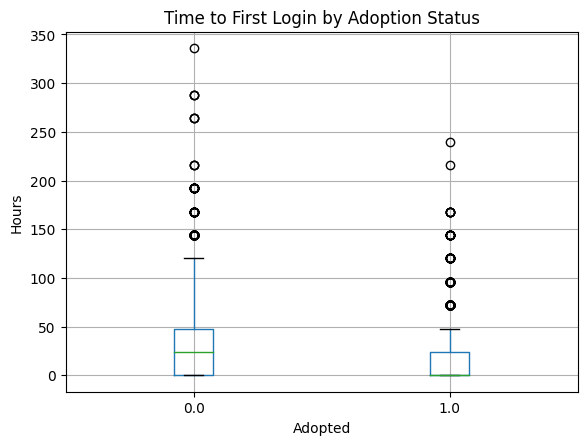

In [21]:
plt.figure()
users.boxplot(column='time_to_first_login', by='adopted')
plt.title("Time to First Login by Adoption Status")
plt.suptitle("")
plt.xlabel("Adopted")
plt.ylabel("Hours")
plt.show()

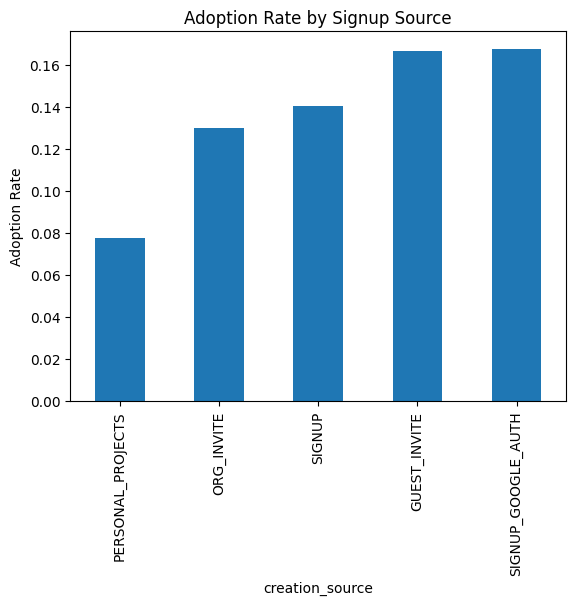

In [22]:
adoption_by_source = users.groupby('creation_source')['adopted'].mean()

plt.figure()
adoption_by_source.sort_values().plot(kind='bar')
plt.title("Adoption Rate by Signup Source")
plt.ylabel("Adoption Rate")
plt.show()

In [23]:
engagement['hour'] = engagement['time_stamp'].dt.hour
engagement['day_of_week'] = engagement['time_stamp'].dt.dayofweek

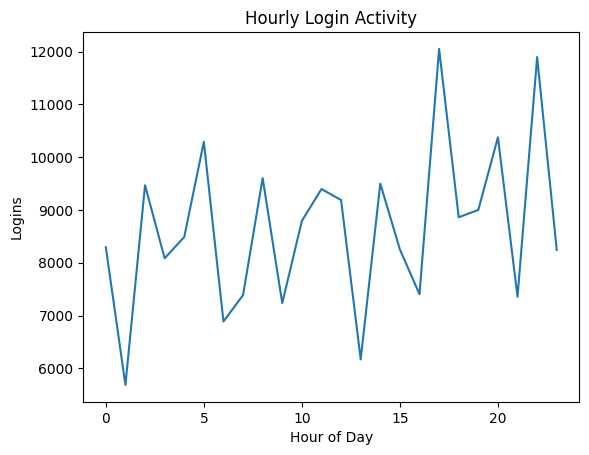

In [24]:
plt.figure()
engagement.groupby('hour').size().plot()
plt.title("Hourly Login Activity")
plt.xlabel("Hour of Day")
plt.ylabel("Logins")
plt.show()

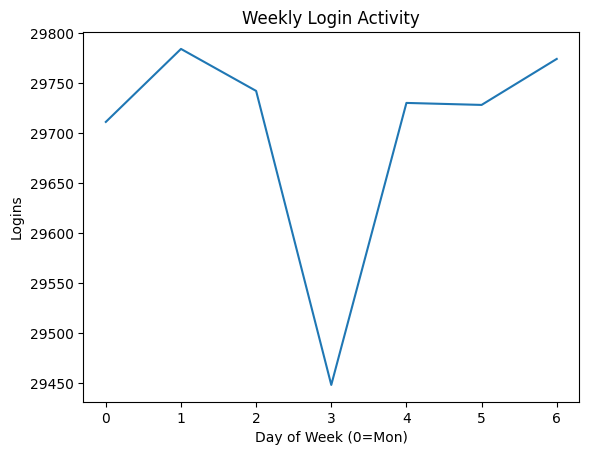

In [25]:
plt.figure()
engagement.groupby('day_of_week').size().plot()
plt.title("Weekly Login Activity")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Logins")
plt.show()

In [26]:
features = users[
    [
        'invited',
        'opted_in_to_mailing_list',
        'enabled_for_marketing_drip',
        'time_to_first_login'
    ]
]

features = pd.get_dummies(
    pd.concat([features, users['creation_source']], axis=1),
    drop_first=True
)

X = features.fillna(features.median())
y = users['adopted']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [29]:
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.5790674019272928


In [30]:
print(classification_report(y_test, model.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      3119
         1.0       0.00      0.00      0.00       481

    accuracy                           0.87      3600
   macro avg       0.43      0.50      0.46      3600
weighted avg       0.75      0.87      0.80      3600



/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
0,invited,0.128625
7,creation_source_SIGNUP_GOOGLE_AUTH,0.066637
6,creation_source_SIGNUP,0.020636
1,opted_in_to_mailing_list,0.009320
2,enabled_for_marketing_drip,0.003149
3,time_to_first_login,-0.046812
4,creation_source_ORG_INVITE,-0.141160
5,creation_source_PERSONAL_PROJECTS,-0.245608
